# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
%matplotlib inline

from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


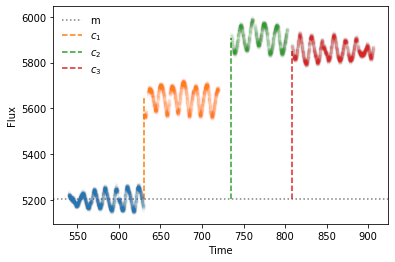

In [2]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [3]:
import george
from george import kernels

def kernel(A, gamma,logP, lam):
    return A*kernels.ExpSine2Kernel(gamma=gamma, log_period=logP)*kernels.ExpSquaredKernel(metric=lam)

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

### To define the cycles, we'll figure out the start time of each cycle, which really defines the end time of the constant value for the previous cycle

In [4]:
transition_times = {key: tab[ind]['time'].min() for key, ind in cycle_map.items()}
print(transition_times)

{6: 539.4710179205795, 7: 630.1958363732629, 8: 735.40366757843, 9: 808.5360293126505}


In [5]:
from george.modeling import Model
class kepler_mean_model(Model):
    parameter_names = ("m", "c1", "c2", "c3")
    def get_value(self, t):
        
        t = t.flatten()
        # the baseline model is the mean m
        mean_model = np.repeat(self.m, len(t))
        
        # each cycle after 6 has it's own offset
        # you could do this with a single dictionary/list comprehension 
        ind = (t >= transition_times[7]) & (t < transition_times[8])
        mean_model[ind] += self.c1
        ind = (t >= transition_times[8]) & (t < transition_times[9])
        mean_model[ind] += self.c2
        ind = t >= transition_times[9]
        mean_model[ind] += self.c3
        
        return mean_model       

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [6]:
# First we'll do initial guesses:

# means and offsets are easy
m = means[0]
c1, c2, c3 = means[1:] - m

# just use the stddev for the first cycle to get some scale for the amplitude
A = tab['flux'][cycle_map[6]].std() 

# gamma is modulating the periodic variation - we'll just set it to 1.
gamma= 1.

# squiggles are roughly every 15 days from the plot
logP = np.log(15.)

# long-period variations are on the scale of the Kepler cycles - from cycle 8/9, this is maybe 150 days
lam  = 150

p0 = [m, c1, c2, c3, A, gamma, logP, lam]


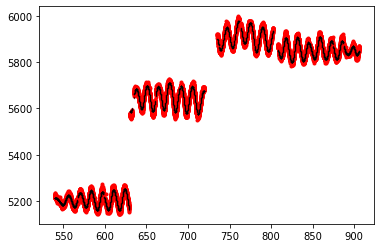

In [7]:
everyn = 30
t = tab['time'][::everyn]
y = tab['flux'][::everyn]
yerr = tab['error'][::everyn]

model = george.GP(mean=kepler_mean_model(m, c1, c2, c3), kernel=kernel(A, gamma, logP, lam))
model.compute(t, yerr)
pred = model.predict(y, tab['time'], return_cov=False)

plot(tab['time'], tab['flux'], 'r.')
plot(tab['time'], pred, 'k.', ms=0.5, alpha=0.5)

In [8]:
# one thing to note is that while you set the parameters in regular space, some are stored, and recovered in logspace
model.get_parameter_dict()

OrderedDict([('mean:m', 5203.7993840014005),
             ('mean:c1', 440.0274367497468),
             ('mean:c2', 702.2100400396093),
             ('mean:c3', 648.388347271658),
             ('kernel:k1:k1:log_constant', 3.3980433624329365),
             ('kernel:k1:k2:gamma', 1.0),
             ('kernel:k1:k2:log_period', 2.70805020110221),
             ('kernel:k2:metric:log_M_0_0', 5.0106352940962555)])

### OK, so even with initial guesses and using only every 30th observation, this is reasonable looking. On to actual priors - we'll define bounds and Gaussian sigmas - note that some of the parameters are in log

In [9]:
guess = [m, c1, c2, c3, np.log(A), gamma, logP, np.log(lam)]

# we can do a tophat on each parameter minimally
bounds = []

# we already have a scale of variation for the mean and offsets
bounds.append((m - 2*A, m+2*A))
bounds.append((c1 - 2*A, c1+2*A))
bounds.append((c2 - 2*A, c2+2*A))
bounds.append((c3 - 2*A, c3+2*A))
# we have some additional constraints, but we'll define this in the log prior function

# don't allow the amplitude to go to 0 - the scale can't be too far off from our initial guess
bounds.append((np.log(0.5*A), np.log(1000*A)))

# no good idea for gamma, but probably shouldn't allow it to be 0
bounds.append((0.1, 100.))

# logP - from the plot, 15 is pretty reasonable - it's not 10 and it's not 20, so lets use those as bounds
bounds.append((np.log(10.), np.log(20.)))

# lam - we know that this is longer than the periodic variations 
bounds.append((np.log(20.), np.log(1000.)))



# we also need to initialize the walkers for emcee so we need some scale parameter
sigma = []

# mean and offset is again easy
sigma.append(10.)
sigma.append(10.)
sigma.append(10.)
sigma.append(10.)

# A
sigma.append(np.log(5.))

# gamma
sigma.append(0.1)

# logP
sigma.append(np.log(2.))

# lambda
sigma.append(np.log(20.))

In [10]:
# so finally our prior is:
def log_prior(p):
    global bounds
    logprior = np.zeros(8)
    for j in range(8):
        limit = bounds[j]
        if (p[j] < limit[0]) or (p[j] > limit[1]):
            return -np.inf
        else:
            logprior[j] = -0.5*((p[j]-guess[j])/(5.*sigma[j]))**2
    
    # force the ordering of the offsets between the cycles
    # this is mostly relevant for cycle 9 - the others should be imposed by the bounds
    if p[1] > p[2]:
        return -np.inf
    
    if p[2] < p[3]:
        return -np.inf
    
    if p[1] > p[3]:
        return -np.inf
        
    return logprior.sum()

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [11]:
import scipy.stats as st
import emcee

In [12]:
# setup the posterior
def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + log_prior(p)

# setup the sampler
nwalkers, ndim = 32, len(model)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# initalize walker positions
p0 = st.norm.rvs(loc=guess, scale=sigma, size=(nwalkers,ndim))

# number of samples
nburn = 500
nsamp = 1000
_ = sampler.run_mcmc(p0, nburn+nsamp, progress=True)

  0%|          | 0/1500 [00:00<?, ?it/s]/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1500/1500 [08:28<00:00,  2.95it/s]


### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

In [13]:
thin = 10
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
sample = sample[::thin,:]

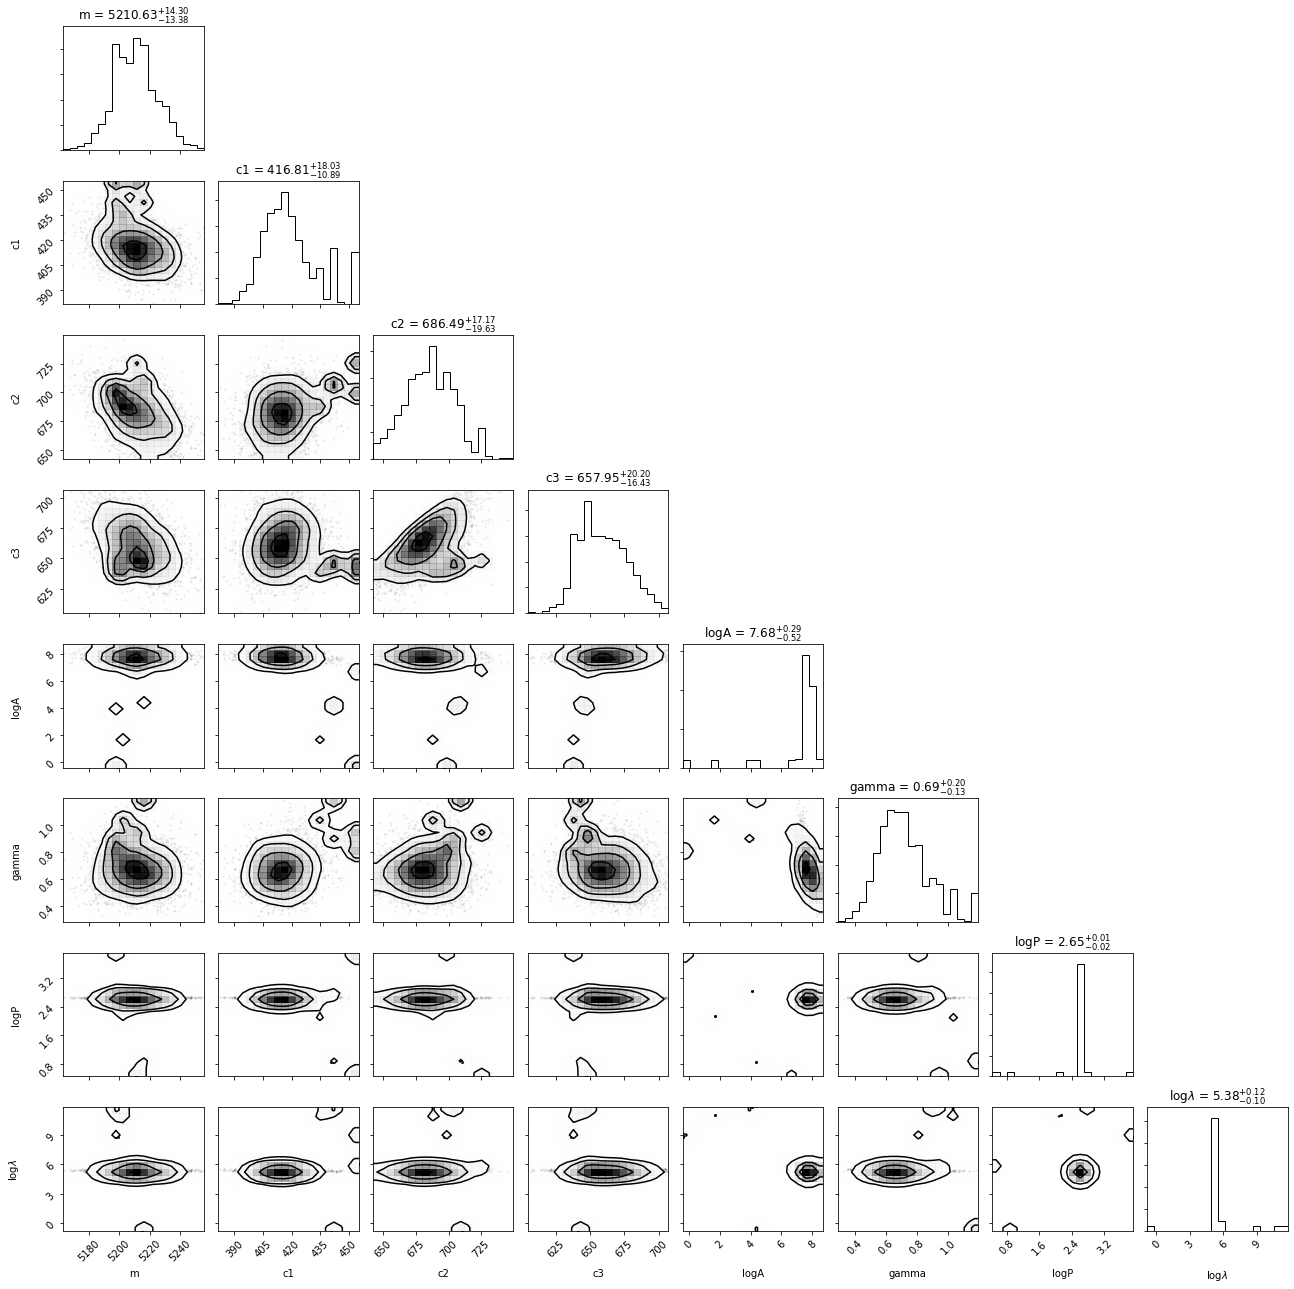

In [14]:
import corner
labels = ['m','c1','c2','c3','logA','gamma','logP',r'log$\lambda$']

fig = corner.corner(sample,labels=labels, plot_contours=True, show_titles=True, smooth=1)
fig.tight_layout()
plt.show()

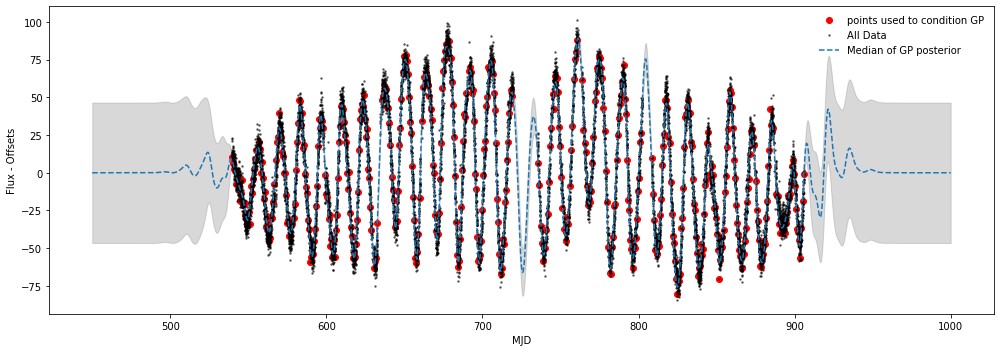

In [15]:
fig, ax = plt.subplots(1,figsize=(14,5))
tgrid = np.linspace(450, 1000, 1001)
stats = np.percentile(sample, [50, 16, 84], axis=0)
res = stats[0]
model.set_parameter_vector(res)

yfull, cov = model.predict(y, tgrid, return_cov=True)
err = np.sqrt(np.diag(cov))

tall = tab['time']
yres = y - model.mean.get_value(t)
yall = tab['flux']-model.mean.get_value(tall)
ypred = yfull-model.mean.get_value(tgrid)


plot(t, yres, 'ro', label='points used to condition GP')
plot(tall, yall, 'k.', ms=3, alpha=0.5, label='All Data')
plot(tgrid, ypred, color='C0',linestyle='--', label='Median of GP posterior')
fill_between(tgrid, ypred-err, ypred+err, color='grey', alpha=0.3)

ax.set_xlabel('MJD')
ax.set_ylabel('Flux - Offsets')
ax.legend(frameon=False)
    
fig.tight_layout()

### Note that we've only subtracted off constants - the DC flux offsets if you like. 

### The signal on top of those offsets is what is physically interesting and includes the quasi-periodic variations, which the GP has modeled quite admirably - particularly in the gaps between cycles, where there is no data at all. 

### The extrapolation is also believable for a bit  though of course goes to 0 since we specified the mean model as just constants (that are subtracted off here, hence 0).